In [51]:
#include("../DMSpecacim/DiscreteMaps.jl")
include("DiscreteMaps.jl")
using DiscreteMaps, Gadfly
DM = DiscreteMaps
M = 20
deps = 1e-6
Mp = [x=>DM.logistic(x(3.8,M*deps/2)) for x in [+,-]]
CO = [x=>DM.logisticcriticalorbit(Mp[x]) for x in [+,-]]
#COspds = 
mu = [x=>DM.spectralacim(Mp[x],200,uselogisticcofn=true) for x in [+,-]];

In [50]:
#Gadfly.plot([plotmeasure(mu[+];col=color("blue")),
#    plotmeasure(mu[-];col=color("green"))],Scale.x_continuous(minvalue=0.58,maxvalue=0.6))
N = 10^8
xh = [x=>DM.iterate(Mp[x],10^8) for x in [+,-]]

LoadError: interrupt
while loading In[50], in expression starting on line 4

In [53]:
meshf = 10000
boxsize = 0.9/meshf
hgd = linspace(0.05+5e-6,0.95-5e-6,meshf+1)
pgd = hgd[1:end-1] + boxsize/2
#xhcts = [x => hist(xh[x],hgd)[2]/boxsize/N for x in [+,-]]
mp = [x=>DM.measureint(hgd,mu[x])[1] * 10^8 for x in [+,-]];

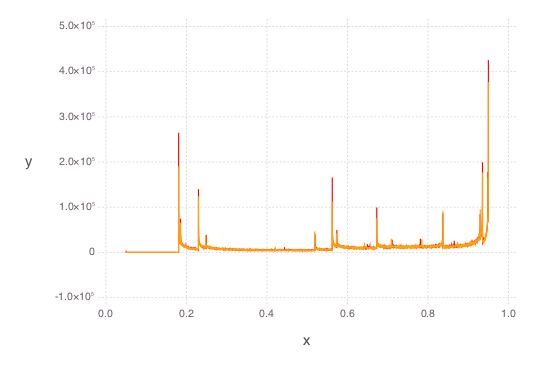

In [55]:
# can we see any good peaks by eye?
col = [(+)=>"orange",(-)=>"red"]
# this plot is a stand-in for iterating (I'm too lazy)
plot([layer(x=pgd,y=mp[x]+sqrt(abs(mp[x])).*randn(meshf),Geom.line,Theme(default_color=color(col[x])))[1] for x in [+,-]]...)
#plot([layer(x=xh[x],Geom.histogram,Theme(default_color=color(col[x])))[1] for x in [+,-]])

In [70]:
n_byeye = find(0.40 .< DiscreteMaps.criticalorbit(DiscreteMaps.logistic(3.8)).pts .< 0.45)[1]
n_byeyelr = find(0.80 .< DiscreteMaps.criticalorbit(DiscreteMaps.logistic(3.8)).pts .< 0.82)[1]
depsm = M/2 * deps
n_star = - log(depsm) / 2log(mean([DM.lyapunov(Mp[x],mu[x]) for x in [+,-]])) |> round |> int
n_one = 1
nv = [n_one,n_star,n_byeye,n_byeyelr]

4-element Array{Int64,1}:
  1
 13
 18
 22

In [64]:
# how far apart are the peaks
DM.logisticcriticalorbit(Mp[+]).pts[nv] - 
    DM.logisticcriticalorbit(Mp[-]).pts[nv]

3-element Array{Float64,1}:
  5.0e-6    
 -0.00111953
  0.256914  

In [77]:
addprocs(4-nprocs())

@everywhere include("DiscreteMaps.jl")

@everywhere module expas
    using DiscreteMaps
    alpha = 3.8
    copts = DiscreteMaps.logisticcriticalorbit(DiscreteMaps.logistic(alpha)).pts |> vec
    gauA(stdv,ns) = [DiscreteMaps.gaussian(copts[i],std) for std in stdv,i in ns] |> vec
    logisticgs(stdv,ns;largs...) = DiscreteMaps.IterationSchema(DiscreteMaps.logisticp(alpha),"Lgs",gauA(stdv,ns);largs...)
    end

@everywhere setupcode = quote
    nv = [1,13,18,22]
    using DiscreteMaps
    

    using expas
    function peturbsample(M,deps,kr)
        N = 10^8
        NH = 10^2
        DiscreteMaps.timedsample(expas.logisticgs(2. .^(-[1:0.5:27]),nv,
            samplefn=DiscreteMaps.evensamplefn,samplefnargs=(deps),N=N,NH=NH),
            NP=M,NCycles=1,startstring="results/lrb/rbugs-$(deps)-$(kr)-")
    end
end
@everywhere eval(setupcode)
peturbsample(M,deps,1.);

exception on 1: ERROR: setupcode not defined
 in eval at /Applications/Julia-0.3.7.app/Contents/Resources/julia/lib/julia/sys.dylib
 in anonymous at multi.jl:1310
 in run_work_thunk at multi.jl:621
 in run_work_thunk at multi.jl:630
 in anonymous at task.jl:6


LoadError: peturbsample not defined
while loading In[77], in expression starting on line 28

Master process (id 1) could not connect within 60.0 seconds.
exiting.
Master process (id 1) could not connect within 60.0 seconds.
exiting.
Master process (id 1) could not connect within 60.0 seconds.
exiting.


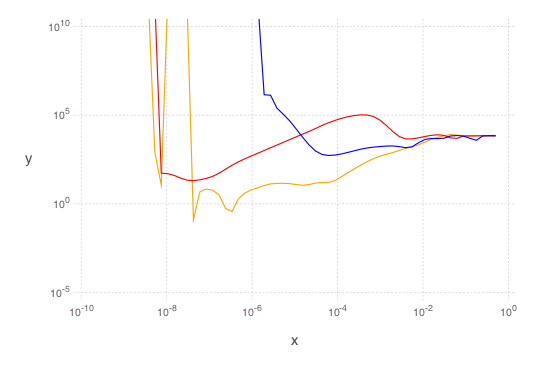

In [75]:
include("DiscreteMaps.jl")
using HDF5, JLD, DiscreteMaps
L = load("../Dropbox/results/lrb/rbugs-1.0e-6-1.0--Lgs-2015-07-14T10-00-00--12-35-s.h5")
rss = DiscreteMaps.checklinearresponse(L)[1]
chim = reshape(rss,(59,3))
col2 = ["blue","red","orange"]
layerm = Layer[]
for i = 1:3
    append!(layerm,layer(x=2.^(-[1:0.5:30]),y=max(0,chim[:,i]-(M-2)),Geom.line,
    Theme(default_color=color(col2[i]))))
end
plot(layerm,Scale.x_log10,Scale.y_log10(maxvalue=10^10))

In [188]:
# does the lyapunov exponent thing work?
x1 = rand(1)
x2 = x1 + 1e-7
rp = 10
for i = 1:rp
    Mp[+].f!(x1,Mp[+].params)
    Mp[+].f!(x2,Mp[+].params)
end
(abs(x2 - x1)/1e-7).^(1/2rp)

1-element Array{Float64,1}:
 1.16348

In [63]:
# does the lyapunov-speeds-alpha thing work?
include("DiscreteMaps.jl")
using DiscreteMaps
DM = DiscreteMaps
lyk = Float64[]
alphak = Float64[]
alspdk = Float64[]
x = [1:100]
for k in 3.75:0.001:3.8
    Mpk = DM.logistic(k)
    COk = DM.logisticcriticalorbit(Mpk)
    y = COk.mag
    z = abs(DM.logisticcospeeds(COk,Mpk))
    push!(alphak, exp(-cov(x,log(y[:]))/var(x))[1])
    push!(lyk, DM.lyapunov(Mpk,DM.spectralacim(Mpk))[1])
    push!(alspdk, exp(-cov(x,log(z[:]))/var(x))[1])
end

In [14]:
[i for std in 2. .^[-1:0.5:30],i in nv] |> vec

189-element Array{Any,1}:
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  ⋮
 22
 22
 22
 22
 22
 22
 22
 22
 22
 22
 22
 22